# TF 경고 끄기

In [1]:
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# 학습 파라미터

In [29]:
train_batch_size = 32
train_image_size = 256
train_stride = 128

train_epoch = 5
train_learning_rate = 1e-4

train_alpha = 200    # PSNR
train_beta = 50      # SSIM
train_lambda = 100    # Reonconstruction

# 학습 데이터셋 불러오기

In [22]:
import os
import numpy as np

from glob import glob

import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle


def train_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32) / 255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32) / 255
    inp, targ = augmentation(inp, targ)
    return inp, targ


def val_map_func(inp_path, targ_path):
    inp = np.load(inp_path)
    inp = inp.astype(np.float32) / 255
    targ = np.load(targ_path)
    targ = targ.astype(np.float32) / 255
    return inp, targ


def augmentation(inp, targ):
    inp, targ = random_rot(inp, targ)
    inp, targ = random_flip(inp, targ)
    return inp, targ


def random_rot(inp, targ):
    k = np.random.randint(4)
    inp = np.rot90(inp, k)
    targ = np.rot90(targ, k)
    return inp, targ


def random_flip(inp, targ):
    f = np.random.randint(2)
    if f == 0:
        inp = np.fliplr(inp)
        targ = np.fliplr(targ)
    return inp, targ


def read_raw_dataset_list(path):
    train_csv = pd.read_csv(os.path.join(path, 'train.csv'))
    test_csv = pd.read_csv(os.path.join(path, 'test.csv'))
    
    train_input_all_files = os.path.join(path, 'train_input_img') + os.path.sep + train_csv['input_img']
    train_label_all_files = os.path.join(path, 'train_label_img') + os.path.sep + train_csv['label_img']
    
    test_all_files = os.path.join(path, 'test_input_img') + os.path.sep + test_csv['input_img']
    submission_all_files = os.path.join(path, 'test_input_img') + os.path.sep + test_csv['submission_name']
    
    train_input_files = train_input_all_files[60:].to_numpy()
    train_label_files = train_label_all_files[60:].to_numpy()
    val_input_files = train_input_all_files[:60].to_numpy()
    val_label_files = train_label_all_files[:60].to_numpy()
    return train_input_files, train_label_files, val_input_files, val_label_files, test_all_files, submission_all_files


def create_dataset_generator(path, batch_size, image_size):
    train_input_files = glob(os.path.join(path, f'train_input_img_{image_size}', '*.npy'))
    train_label_files = glob(os.path.join(path, f'train_label_img_{image_size}', '*.npy'))
    val_input_files = glob(os.path.join(path, f'val_input_img_{image_size}', '*.npy'))
    val_label_files = glob(os.path.join(path, f'val_label_img_{image_size}', '*.npy'))
    train_input_files, train_label_files = shuffle(train_input_files, train_label_files, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((train_input_files, train_label_files))
    train_dataset = train_dataset.map(lambda i1, i2: tf.numpy_function(train_map_func, [i1, i2], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_input_files, val_label_files))
    val_dataset = val_dataset.map(lambda i1, i2: tf.numpy_function(val_map_func, [i1, i2], [tf.float32, tf.float32]),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size)
    val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return train_dataset, val_dataset

In [4]:
train_generator, validate_generator = create_dataset_generator('.\\LG_Data', train_batch_size, train_image_size)

# ResUNet101V2 신경망 모델
영상 재건을 위한 ResUNet101V2 모델을 정의합니다.

In [5]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = tf.keras.layers.Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if activation == True:
        x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    return x


def residual_block(blockInput, num_filters=16):
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(blockInput)
    x = tf.keras.layers.BatchNormalization()(x)
    blockInput = tf.keras.layers.BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = tf.keras.layers.Add()([x, blockInput])
    return x


def ResUNet101V2(image_size, weights='imagenet', dropout_rate=0.1, start_neurons=16):
    input_shape=(image_size, image_size, 3)
    backbone = tf.keras.applications.ResNet101V2(weights=weights, include_top=False, input_shape=input_shape)
    input_layer = backbone.input

    conv4 = backbone.layers[122].output
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(dropout_rate)(pool4)

    convm = tf.keras.layers.Conv2D(start_neurons * 32, (3, 3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons * 32)
    convm = residual_block(convm, start_neurons * 32)
    convm = tf.keras.layers.LeakyReLU(alpha=0.1)(convm)

    deconv4 = tf.keras.layers.Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding='same')(convm)
    uconv4 = tf.keras.layers.concatenate([deconv4, conv4])
    uconv4 = tf.keras.layers.Dropout(dropout_rate)(uconv4)

    uconv4 = tf.keras.layers.Conv2D(start_neurons * 16, (3, 3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons * 16)
    uconv4 = residual_block(uconv4, start_neurons * 16)
    uconv4 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv4)

    deconv3 = tf.keras.layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding='same')(uconv4)
    conv3 = backbone.layers[76].output
    uconv3 = tf.keras.layers.concatenate([deconv3, conv3])
    uconv3 = tf.keras.layers.Dropout(dropout_rate)(uconv3)

    uconv3 = tf.keras.layers.Conv2D(start_neurons * 8, (3, 3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons * 8)
    uconv3 = residual_block(uconv3, start_neurons * 8)
    uconv3 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = tf.keras.layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding='same')(uconv3)
    conv2 = backbone.layers[30].output
    uconv2 = tf.keras.layers.concatenate([deconv2, conv2])

    uconv2 = tf.keras.layers.Dropout(0.1)(uconv2)
    uconv2 = tf.keras.layers.Conv2D(start_neurons * 4, (3, 3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons * 4)
    uconv2 = residual_block(uconv2, start_neurons * 4)
    uconv2 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv2)

    deconv1 = tf.keras.layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding='same')(uconv2)
    conv1 = backbone.layers[2].output
    uconv1 = tf.keras.layers.concatenate([deconv1, conv1])

    uconv1 = tf.keras.layers.Dropout(0.1)(uconv1)
    uconv1 = tf.keras.layers.Conv2D(start_neurons * 2, (3, 3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons * 2)
    uconv1 = residual_block(uconv1, start_neurons * 2)
    uconv1 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv1)

    uconv0 = tf.keras.layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding='same')(uconv1)
    uconv0 = tf.keras.layers.Dropout(0.1)(uconv0)
    uconv0 = tf.keras.layers.Conv2D(start_neurons * 1, (3, 3), activation=None, padding='same')(uconv0)
    uconv0 = residual_block(uconv0, start_neurons * 1)
    uconv0 = residual_block(uconv0, start_neurons * 1)
    uconv0 = tf.keras.layers.LeakyReLU(alpha=0.1)(uconv0)

    uconv0 = tf.keras.layers.Dropout(dropout_rate / 2)(uconv0)
    output_layer = tf.keras.layers.Conv2D(3, (1, 1), padding='same', activation='sigmoid')(uconv0)

    model = tf.keras.models.Model(input_layer, output_layer)

    return model

# 손실 함수 정의
* 학습에 사용할 손실 함수를 정의합니다.

 $Loss = αL2 + βSSIM + λL1$

1. 왜 PSNR 대신 L2(MSE; Mean Squared Error) 손실 함수를 사용하였는가?
- 보편적인 손실 함수와 달리 PSNR은 최소가 아닌 최대를 찾아야하므로 다른 손실 함수와 조합이 어려움
- 또, PSNR의 최소값은 정의되어있으나, 최대값은 정의되지 않아 학습 중 NaN으로 발산 하여 학습이 진행 되지 않음
- 따라서, PSNR을 간접적으로 최적화 할 수 있는 L2 손실 함수를 사용

 $PSNR(x,y) = 10log_{10}(\frac{MAX^2}{MSE(x,y)})$

 L2(MSE)는 PSNR의 분모이고 학습단계에서 작아지므로 결과적으로 PSNR은 커지게됨

2. SSIM(Structual Similarity Index Map)은 무엇인가?
- SSIM은 밝기(Luminance), 명암비(Contrast), 구조(Structural) 이 3가지 지표를 영상 품질 지표로 사용
- PSNR은 원본 영상과의 차이를 지표로 사용하지만, 원본 영상과의 차이가 인간 시각의 지각품질을 완벽히 반영하지 못함

 $SSIM(x,y) = L(x,y) + C(x,y) + S(x,y)$
 
3. 왜 L1(MAE; Mean Absolute Error) 손실 함수도 사용되었는가?
- GAN, Pix2Pix와 같은 생성 모델에서 L1 손실 함수를 Adversarial Loss와 함께 재건항(Reconstruction Loss)로 사용됨
- 해당 모델들의 결과에 의하면 L2 손실 함수를 재건항으로 사용하게 되면 영상이 흐려지는 문제(Blurring)가 있음

In [30]:
def psnr_loss(y_true, y_pred):
    return tf.keras.losses.mean_squared_error(y_true, y_pred)

def ssim_loss(y_true, y_pred):
    return 1. - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def recon_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred)

def create_psnr_ssim_recon_combined_loss(alpha_, beta_, lambda_):
    def psnr_ssim_recon_combined_loss(y_true, y_pred):
        return (alpha_ * psnr_loss(y_true, y_pred)) + (beta_ * ssim_loss(y_true, y_pred)) + (lambda_ * recon_loss(y_true, y_pred))
    return psnr_ssim_recon_combined_loss

combined_loss = create_psnr_ssim_recon_combined_loss(train_alpha, train_beta, train_lambda)

# 모델 생성

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=train_learning_rate)
model = ResUNet101V2(train_image_size)
model.compile(optimizer=optimizer, loss=combined_loss)

# 모델 학습

In [32]:
model_name = f'ResUNet101V2_RGB_PSNR+SSIM+Recon_{train_image_size}_alpha_{train_alpha}_beta_{train_beta}_lambda_{train_lambda}'

train_history = model.fit(train_generator, epochs=train_epoch, validation_data=validate_generator, callbacks=[
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{model_name}_epoch_{train_epoch}_best.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'{model_name}_epoch_{train_epoch}_last.h5',
        save_freq=512
    )
])

Epoch 1/5
 512/4867 [==>...........................] - ETA: 38:03 - loss: 60.6439

c:\users\pr0ximo\venv39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


4867/4867 [==============================] - 2750s 563ms/step - loss: 23.0481 - val_loss: 6.3971
Epoch 2/5
4867/4867 [==============================] - 2745s 564ms/step - loss: 8.9500 - val_loss: 7.3237
Epoch 3/5
4867/4867 [==============================] - 2753s 566ms/step - loss: 7.3983 - val_loss: 6.3102
Epoch 4/5
4867/4867 [==============================] - 2753s 566ms/step - loss: 6.7471 - val_loss: 6.0148
Epoch 5/5
4867/4867 [==============================] - 2751s 565ms/step - loss: 6.3646 - val_loss: 6.3281


# 영상 품질 평가 함수 정의

In [9]:
import math
import numpy as np


def rmse_score(true, pred):
    score = math.sqrt(np.mean((true - pred) ** 2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20 * np.log10(pixel_max / rmse_score(true,pred))
    return score

# 추론 함수 정의

In [10]:
import cv2
import numpy as np
from tqdm import tqdm


def predict(model, img_paths, image_size, stride, batch_size):
    results = []
    for i, img_path in enumerate(img_paths):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = img.astype(np.float32) / 255
        crop = []
        position = []
        batch_count = 0
        
        result_img = np.zeros_like(img)
        voting_mask = np.zeros_like(img)
        for top in tqdm(range(0, img.shape[0], stride), desc=f'Predicting ({i + 1}/{len(img_paths)})'):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([image_size, image_size, 3], np.float32)
                temp = img[top:top + image_size, left:left + image_size, :]
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                crop.append(piece)
                position.append([top, left])
                batch_count += 1
                if batch_count == batch_size:
                    crop = np.array(crop)
                    pred = model(crop) * 255
                    crop = []
                    batch_count=0
                    for num, (t, l) in enumerate(position):
                        piece = pred[num]
                        h, w, c = result_img[t:t + image_size, l:l + image_size,:].shape
                        result_img[t:t + image_size, l:l + image_size,:] += piece[:h, :w]
                        voting_mask[t:t + image_size, l:l + image_size, :] += 1
                    position = []
                    
        result_img = result_img / voting_mask
        result_img = result_img.astype(np.uint8)
        results.append(result_img)
        
    return results

# 빚번짐 제거 실험

In [ ]:
# 기존 모델 로딩
fronzen_model_filename = 'ResUNet101V2_RGB_PSNR+SSIM+Recon_256_alpha_10_beta_5_lambda_20_epoch_5_best.h5'
model = tf.keras.models.load_model(fronzen_model_filename, custom_objects={combined_loss.__name__: combined_loss})

In [33]:
train_input_files, train_label_files, val_input_files, val_label_files, _, _ = read_raw_dataset_list('.\\LG_Raw_Data')

In [34]:
pred_image_size = 256
pred_stride = 32
pred_batch_size = 32

In [35]:
input_images = [cv2.imread(fn, cv2.IMREAD_COLOR) for fn in val_input_files[:1]]
label_images = [cv2.imread(fn, cv2.IMREAD_COLOR) for fn in val_label_files[:1]]
predicted_images = predict(model, val_input_files[:1], pred_image_size, pred_stride, pred_batch_size)

Predicting (1/1): 100%|████████████████████████████████████████████████████████████████| 77/77 [00:54<00:00,  1.42it/s]


PSNR: 30.73854687801695


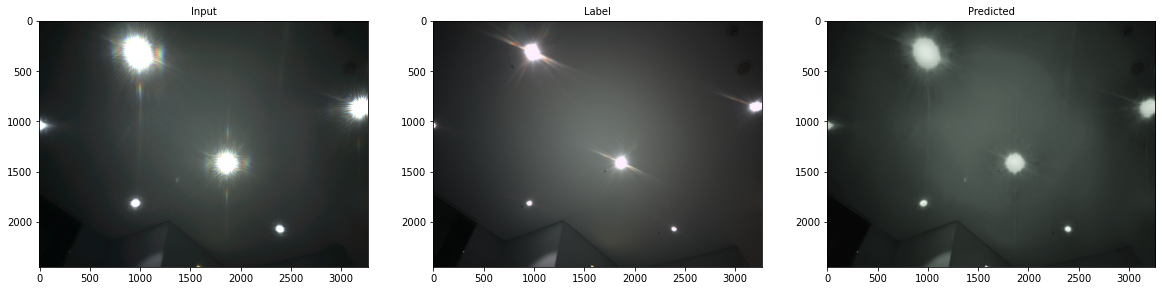

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(input_images[0])
plt.title('Input', fontsize=10)
plt.subplot(1, 3, 2)
plt.imshow(label_images[0])
plt.title('Label', fontsize=10)
plt.subplot(1, 3, 3)
plt.imshow(predicted_images[0])
plt.title('Predicted', fontsize=10)

print(f'PSNR: {psnr_score(label_images[0], predicted_images[0], 255)}')

# 결과 제출

In [37]:
import os
import zipfile
from tqdm import tqdm


def make_submission(result):
    root_path = 'submission'
    os.makedirs(root_path, exist_ok=True)
    with zipfile.ZipFile("submission.zip", 'w') as submit:
        for i, img in tqdm(enumerate(result), total=len(result)):
            arcname = f'test_{20000 + i}.png'
            absname = os.path.join(root_path, arcname)
            cv2.imwrite(absname, img)
            submit.write(absname, arcname)

In [38]:
import cv2

_, _, _, _, test_all_files, _ = read_raw_dataset_list('.\\LG_Raw_Data')
test_input_images = [cv2.imread(fn, cv2.IMREAD_COLOR) for fn in test_all_files]
predicted_images = predict(model, test_all_files, pred_image_size, pred_stride, pred_batch_size)
make_submission(predicted_images)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.82it/s]


In [ ]:
make_submission(predicted_images)